In [1]:
# # Load the Drive helper and mount.
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

In [2]:
!pip install category_encoders
!pip install Unidecode
!pip install nltk

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [7]:
import itertools, os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msgn
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import pandas as pd
from category_encoders import TargetEncoder
from unidecode import unidecode
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.base import clone
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import xgboost as xgb
import matplotlib.pyplot as plt


sys.path.append("../src")

from preprocess import BuildFeature
from utils import load_dataset, get_weights, plot_confusion_matrix
from ordinal_classifier import OrdinalClassifier
matplotlib.rcParams['figure.figsize'] = (10,6)

### Preprocessing

In [8]:
feat_build = BuildFeature()

df_ = load_dataset()

df, feature_names = feat_build.transform(df_)

print("feature names: ", feature_names)

X = df.drop('target', axis=1).values
y = df['target'].values

print("Shape X:", X.shape)
print("shape y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(pd.Series(y_test).value_counts())
print("train size", X_train.shape)
print(y_train.shape)
print("test size:", X_test.shape)
print(y_test.shape)

feature names:  ['product_id', 'site_category_lv1', 'site_category_lv2', 'recommend_to_a_friend', 'review_title', 'review_text', 'len_review_text', 'len_review_title']
Shape X: (105898, 8)
shape y: (105898,)
5    7735
4    5155
1    4395
3    2596
2    1299
dtype: int64
train size (84718, 8)
(84718,)
test size: (21180, 8)
(21180,)


## Ordinal Classification

###  XGBoost

In [5]:
params = {'booster': 'gbtree', 'learning_rate': 0.01,
          'n_estimators': 300, 'max_depth': 16,
          'objective': 'multi:softmax', 'num_class':2, #'binary:logistic'
          'seed': 142} 

gbm = xgb.XGBClassifier(**params)

ord_clfr = OrdinalClassifier(gbm)
ord_clfr.fit(X_train, y_train)

y_pred = ord_clfr.predict(X_test)
y_score = ord_clfr.predict_proba(X_test)

print(classification_report(y_test, y_pred))


XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=16,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_class=2,
              num_parallel_tree=None, objective='multi:softmax',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, seed=142, subsample=None, tree_method=None,
              validate_parameters=False, verbosity=None)
Classes: dict_keys([1, 2, 3, 4])
              precision    recall  f1-score   support

           1       0.87      0.91      0.89      4411
           2       0.59      0.51      0.55      1357
           3       0.62      0.50      0.56      2605
           4       0.54      0.59      0.57      51

In [6]:
recall = f1_score(y_test, y_pred, average = 'weighted')
print("recall: ", recall)

recall:  0.6980205239996401


Text(0.5, 1.0, 'expected distribution')

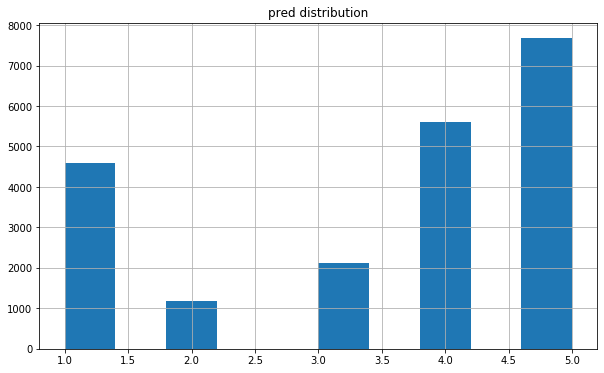

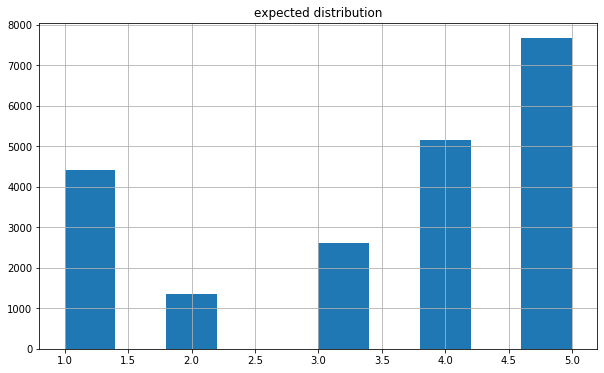

In [7]:
pd.Series(y_pred).hist()
plt.title("pred distribution")
plt.figure()
pd.Series(y_test).hist()
plt.title("expected distribution")

Confusion matrix, without normalization
Normalized confusion matrix


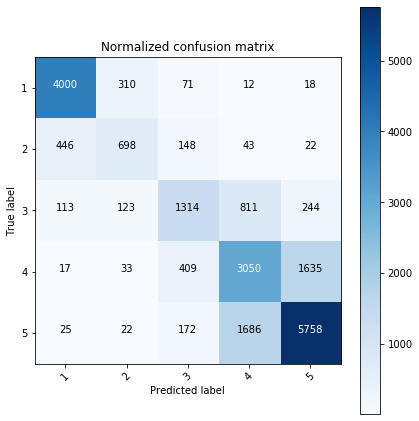

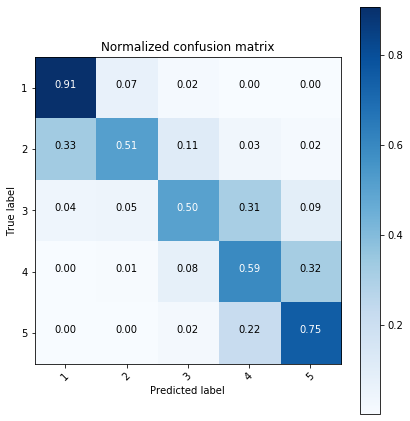

In [8]:
class_names = ord_clfr.classes_

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Cross validation

### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', 
                         max_iter=1000,
                         random_state=0)

ord_clfr = OrdinalClassifier(clf)
ord_clfr.fit(X_train, y_train)

y_pred = ord_clfr.predict(X_test)
y_score = ord_clfr.predict_proba(X_test)

print(classification_report(y_test, y_pred))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Classes: dict_keys([1, 2, 3, 4])
              precision    recall  f1-score   support

           1       0.75      0.99      0.85      4395
           2       0.30      0.06      0.10      1299
           3       0.49      0.46      0.47      2596
           4       0.00      0.00      0.00      5155
           5       0.57      0.94      0.71      7735

    accuracy                           0.61     21180
   macro avg       0.42      0.49      0.43     21180
weighted avg       0.44      0.61      0.50     21180



/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
recall = f1_score(y_test, y_pred, average = 'weighted')
print("recall: ", recall)

recall:  0.5009480124908013


Text(0.5, 1.0, 'expected distribution')

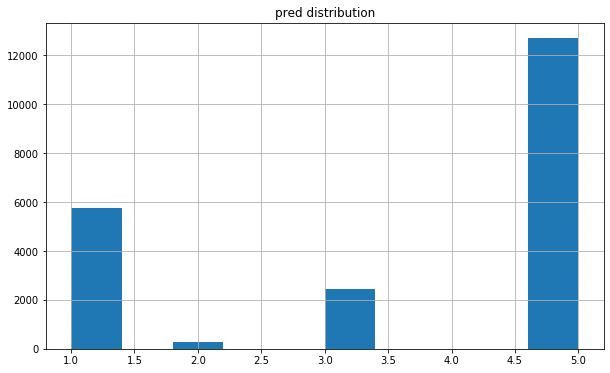

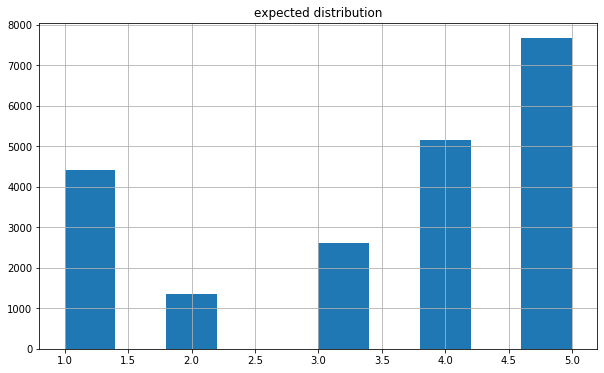

In [12]:
pd.Series(y_pred).hist()
plt.title("pred distribution")
plt.figure()
pd.Series(y_test).hist()
plt.title("expected distribution")

Confusion matrix, without normalization
Normalized confusion matrix


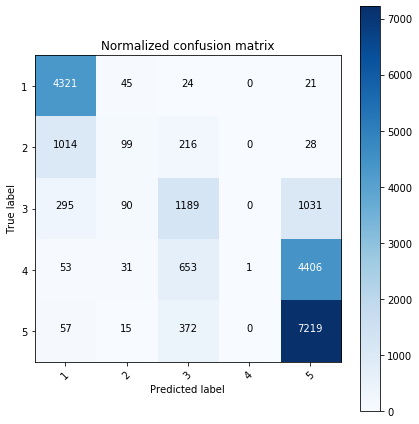

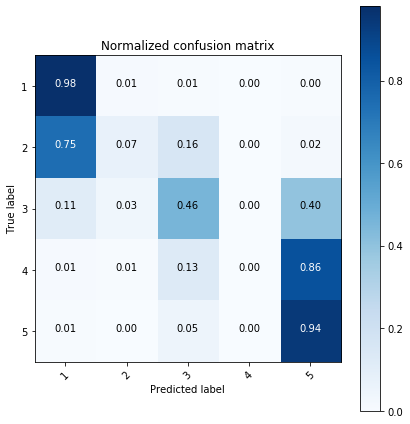

In [14]:
class_names = ord_clfr.classes_

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Nominal Classification

### Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial',
                         class_weight= 'balanced',
                         max_iter=1000, 
                         random_state=0)

clf.fit(X, y)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.82      0.86      4411
           2       0.39      0.57      0.46      1357
           3       0.46      0.54      0.49      2605
           4       0.51      0.43      0.47      5144
           5       0.72      0.73      0.73      7663

    accuracy                           0.64     21180
   macro avg       0.60      0.62      0.60     21180
weighted avg       0.65      0.64      0.65     21180



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
recall = f1_score(y_test, y_pred, average = 'weighted')
print("recall: ", recall)

recall:  0.646286311757735


Text(0.5, 1.0, 'expected distribution')

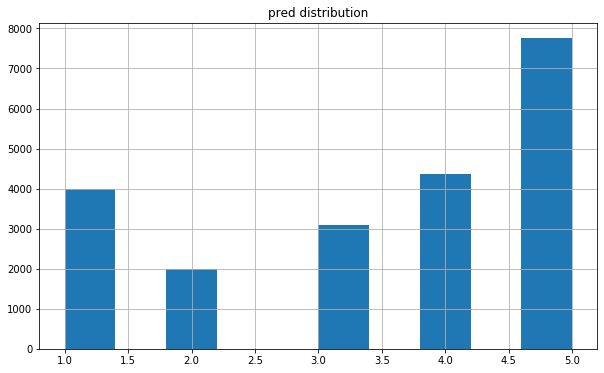

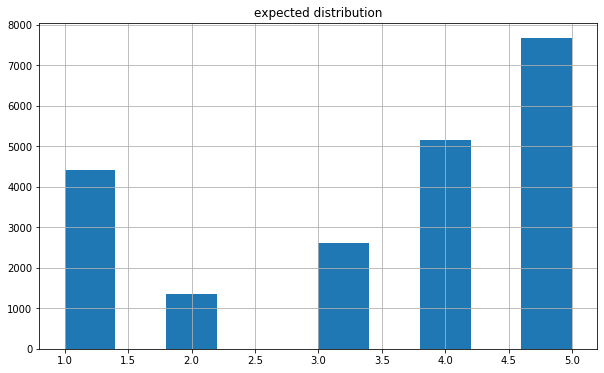

In [17]:
pd.Series(y_pred).hist()
plt.title("pred distribution")
plt.figure()
pd.Series(y_test).hist()
plt.title("expected distribution")

[1 2 3 4 5]
Confusion matrix, without normalization
Normalized confusion matrix


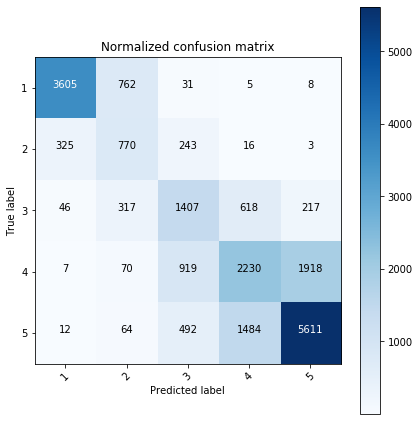

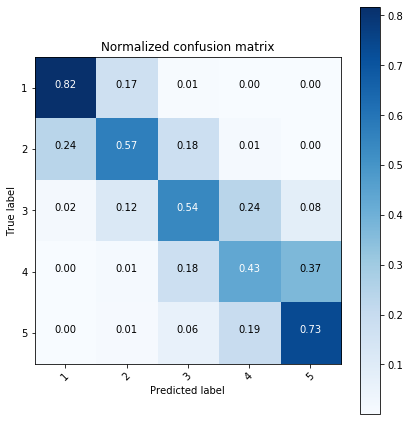

In [18]:
class_names = np.sort(df.target.unique())
print(class_names)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Cross validation

In [ ]:
clf = LogisticRegression(multi_class='multinomial',
                         class_weight= 'balanced',
                         max_iter=1000, 
                         random_state=0)

scores = cross_val_score(clf, X, y, cv=5, scoring='f1_weighted')
print(scores)

### XGBoost


In [19]:
weight_rate = get_weights(y)
seed = 142
num_classes = X.shape[1]

params = {'booster': 'gbtree', 'learning_rate': 0.01,
          'n_estimators': 120, 'max_depth': 16,
          'objective': 'multi:softmax', 'num_class':num_classes,
          'scale_pos_weight': weight_rate, 
          'seed': seed, 'n_jobs':-1
          } 

gbm = xgb.XGBClassifier(**params)

gbm

XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=16,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=-1, num_class=8, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None,
              scale_pos_weight=array([ 3.81, 14.74,  7.14,  3.1 ,  1.76]),
              seed=142, subsample=None, tree_method=None,
              validate_parameters=False, verbosity=None)

In [20]:
gbm.fit(X_train, y_train, verbose=False)

y_pred = gbm.predict(X_test)
y_score = gbm.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.92      0.89      4411
           2       0.63      0.49      0.55      1357
           3       0.60      0.53      0.56      2605
           4       0.58      0.54      0.56      5144
           5       0.73      0.79      0.76      7663

    accuracy                           0.71     21180
   macro avg       0.68      0.65      0.67     21180
weighted avg       0.70      0.71      0.70     21180



In [21]:
recall = f1_score(y_test, y_pred, average = 'weighted')
print("recall: ", recall)

recall:  0.7009270383782937


Text(0.5, 1.0, 'expected distribution')

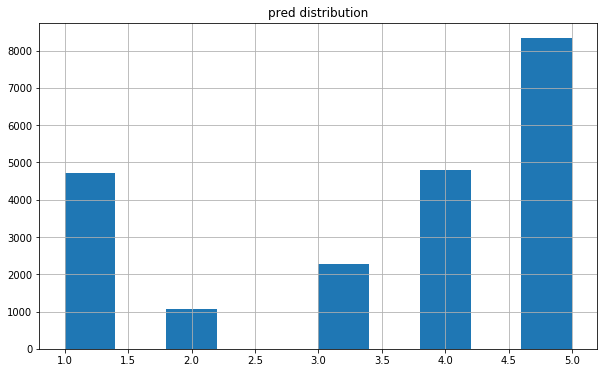

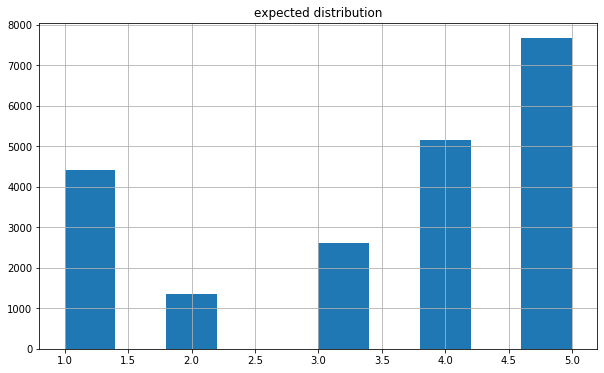

In [22]:
pd.Series(y_pred).hist()
plt.title("pred distribution")
plt.figure()
pd.Series(y_test).hist()
plt.title("expected distribution")

Confusion matrix, without normalization
Normalized confusion matrix


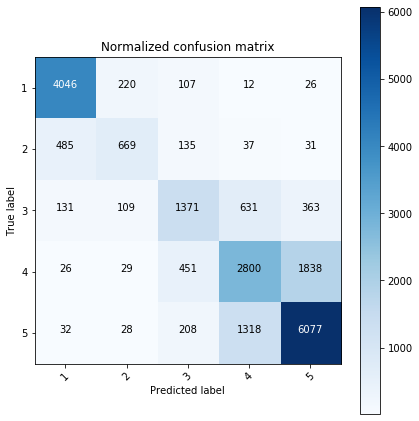

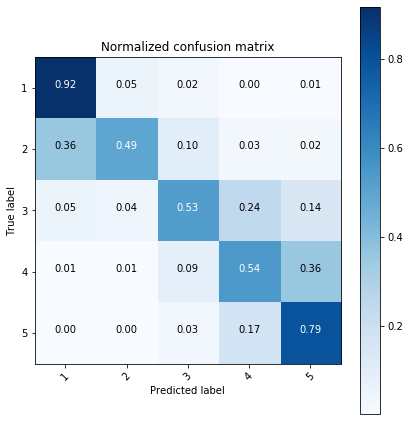

In [23]:
class_names = list(set(y))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Normalized confusion matrix')

plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Cross validation

In [9]:
weight_rate = get_weights(y)
seed = 142
num_classes = X.shape[1]
params = {'booster': 'gbtree', 'learning_rate': 0.01,
          'n_estimators': 120, 'max_depth': 16,
          'objective': 'multi:softmax', 'num_class':num_classes,
          'scale_pos_weight': weight_rate, 
          'seed': seed
          } 

gbm = xgb.XGBClassifier(**params)

scores = cross_val_score(gbm, X, y, cv=5, scoring='f1_weighted')
print(scores)

[0.69375164 0.69844413 0.69615613 0.70153028 0.69724722]


                 feature  importance  cumulative_importance  rank
3  recommend_to_a_friend    0.780170               0.780170     1
5            review_text    0.156810               0.936980     2
4           review_title    0.053793               0.990773     3
0             product_id    0.002542               0.993315     4
7       len_review_title    0.001911               0.995226     5
6        len_review_text    0.001698               0.996924     6
2      site_category_lv2    0.001570               0.998494     7
1      site_category_lv1    0.001506               1.000000     8


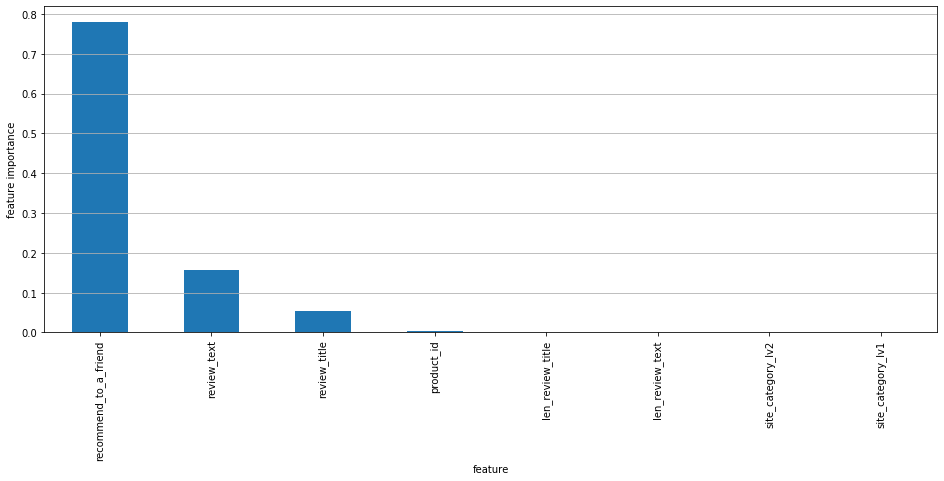

In [24]:

feature_imp = pd.DataFrame({"feature": feature_names, "importance": gbm.feature_importances_})
feature_imp.sort_values(by="importance",ascending=False, inplace=True)
feature_imp["cumulative_importance"] = feature_imp["importance"].cumsum()
feature_imp["rank"] = list(range(1,feature_imp.shape[0] + 1))

print(feature_imp)

fig = plt.figure(figsize=(16,6))
# plt.bar(feature_imp.feature, feature_imp.importance)
feature_imp.groupby("feature").sum()["importance"].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("feature importance")
plt.grid(axis='y')
# plt.tight_layout()

In [27]:
# !pip freeze > ../requirements.txt